In [40]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

# Классификация кандидатов для прохождения стажировки.


---


Рекомендованные кандидаты соответствуют критериям:
- Гражданство РФ
- Студент завершил 3 курса бакалавриата
- Релевантный опыт работы

In [38]:
# Модель обучается на синтетических данных, т.к. нет истории
samples = 10000

# признаки для синтетических данных
citizen = [1, 0]
education = [1, 0]
relevant_experience = [1, 0]

#  список объектов с заданными признаками
data = []
for i in range(samples):
    sample = []
    sample.append(np.random.choice(citizen))
    sample.append(np.random.choice(education))
    sample.append(np.random.choice(relevant_experience))
    data.append(sample)


df = pd.DataFrame(data, columns=['citizen', 'relevant_experience', 'education'])

df['class'] = np.where((df['citizen'] == 1) & (df['relevant_experience'] == 1) & (df['education'] == 1), 1, 0)

df.head(10)

,citizen,relevant_experience,education,class
0,1,1,1,1
1,0,1,1,0
2,1,0,0,0
3,1,1,0,0
4,0,0,0,0
5,0,0,0,0
6,0,0,1,0
7,0,1,0,0
8,0,0,1,0
9,0,1,1,0


In [37]:
df['class'].value_counts()

0    8790
1    1210
Name: class, dtype: int64

In [25]:
data = df[['citizen', 'relevant_experience', 'education']]
data_class = df['class']

In [26]:
# при разделении на тестовую и тренировочную выборки, сохраняю пропорции классов
X_train, X_test, y_train, y_test = train_test_split(data, data_class, random_state=42, stratify=data_class)

In [27]:
lda = LinearDiscriminantAnalysis()

In [28]:
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [29]:
y_pred = lda.predict(X_test)

Text(0.5, 1.0, 'Матрица ошибок для каждого класса')

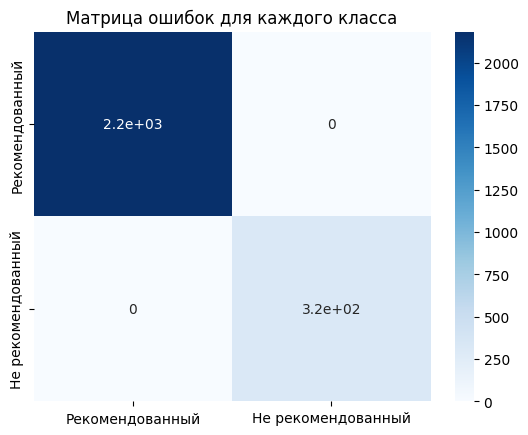

In [30]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues',
            xticklabels=['Рекомендованный', 'Не рекомендованный'],
            yticklabels=['Рекомендованный', 'Не рекомендованный'])
plt.title('Матрица ошибок для каждого класса')

In [31]:
# Проверка 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2183
           1       1.00      1.00      1.00       317

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



#  Подбор рекомендаций знакомств в модуле «Приглашения»

Применения алгоритма коллаборативной фильтрации для определения похожих пользователей (организаций) с помощью косинусного сходства.

Описание:

 класс AIRecommendationEngine использует методы train и recommend. 
 
 Метод train получает на вход DataFrame с колонками id и description, где id - уникальный идентификатор заявки, а description - текстовое описание заявки. На этих данных обучается модель, которая строит векторное представление для каждого описания заявки при помощи метода TfidfVectorizer, использующего алгоритм TF-IDF.

Метод recommend принимает на вход текстовое описание новой заявки и число n, указывающее количество рекомендаций, которые нужно вернуть. В этом методе мы создаем векторное представление для новой заявки и сравниваем его с векторными представлениями всех заявок из обучающей выборки. Затем выбирается n заявок с самыми высокими значениями сходства.

In [ ]:
# из платформы данные беруться в формате json
invitations = pd.read_json('data_invite.json')

In [ ]:
class AIRecommendationEngine:
    def __init__(self):
        self.vectorizer = TfidfVectorizer()
        self.data = None
        
    def train(self, invitations):
        self.data = invitations
        corpus = invitations['description'].values.astype('U')
        self.vectorizer.fit(corpus)
  
    def recommend(self, description, n=5): 
        if self.data is None:
            raise ValueError('the model is not trained')
            
        query_vec = self.vectorizer.transform([description])
        sims = cosine_similarity(query_vec, self.vectorizer.transform(self.data['description']))
        indices = sims.argsort()[0][-n:][::-1]
        return self.data.iloc[indices]